# Web scraping the weekly Japanese hardware videogame sales

First I want to create the code to obtain a dataframe using only one week, to test the functions that I'm going to create to mine the data.

In the block below I am going to import the libraries that I'm using:

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Now I wil use the URL of the post of one random week.

In [2]:
url_tab = 'https://www.resetera.com/threads/media-create-sales-week-53-2020-dec-28-jan-03.356956/'


The function `obtain_table` needs the URL of the post as the input and returns the text table in the code block where the information about the hardware sales is stored.

In [3]:
def obtain_table(url):
    # With request and with the BeautifulSoup class we obtain the code of the page of the URL.
    post = requests.get(url)
    soup = BeautifulSoup(post.text)
    # Obtains the different messages of the post. 
    op=soup.findAll("div", {"class": "message-cell message-cell--main"})
    # We want the first post (op[0]) that is the one with all the info
    # Inside this message, we obtain all the text inside the "code" block, 
    # that is the info we want.
    return op[0].findAll("code")[-1].text

In [4]:
text_table=obtain_table(url_tab)

Let's print here the table to see its structre.

In [5]:
print(text_table)

+-------+------------+------------+------------+------------+------------+-------------+
|System |  This Week |  Last Week |  Last Year |     YTD    |  Last YTD  |     LTD     |
+-------+------------+------------+------------+------------+------------+-------------+
| NSW # |    312.121 |    278.173 |    284.827 |    312.121 |    284.827 |  17.652.495 |
| PS4 # |     17.876 |     12.718 |     58.244 |     17.876 |     58.244 |   9.308.766 |
| PS5 # |     10.632 |     13.188 |            |     10.632 |            |     265.782 |
| 3DS # |        714 |        658 |      4.030 |        714 |      4.030 |  24.559.622 |
| XBS # |        134 |        205 |            |        134 |            |      31.558 |
+-------+------------+------------+------------+------------+------------+-------------+
|  ALL  |    341.477 |    304.942 |    347.213 |    341.477 |    347.213 |  51.818.223 |
+-------+------------+------------+------------+------------+------------+-------------+
|  PS5  |      7.606 

The next step is to create a function that takes this text table as an input and returns it as a dataframe. In addition I will use the year, week and days range as input to store it in the dataframe.

In [6]:
def tab_to_df(text_tab,year,week,days,date):
    tt=[]
    
    # These for bucles creates a nested list with the table
    for element in text_tab.split("+\n"):
        for element2 in element.split("\n"):
            el2=[]
            for el in element2.split("|"):
                if not((el[:1]=="\n") or (el=="") or (el[0]=="+")):
                    text_el=el.replace(".","").replace("#","(All)") # Formating the strings
                    el2.append(text_el)
            if el2 != []:
                tt.append(el2)

    for j in range(0,len(tt[0])):
        # Remove extra spaces in the header
        tt[0][j]=tt[0][j].lstrip().rstrip()
   
    for i in range(1,len(tt)):
        # Remove extra spaces in the name of the system
        tt[i][0]=tt[i][0].lstrip().rstrip() 
        for j in range(1,len(tt[0])):
            # For each cell convert the sales into an integer. 
            # If the cell is empty, avoid the error and put a 0 instead
            try:
                tt[i][j]=int(tt[i][j])
            except ValueError:
                tt[i][j]=0

    # Convert the list into a Pandas DataFrame            
    df = pd.DataFrame(tt[1:],columns=tt[0])
    # Adds in this dataframe a column with the year, the week number,
    # and the range of days in the week
    df["Year"]=year
    df["Week"]=week
    df["Days"]=days
    df["Date"]=date
    
    return df

Now let's see how it works...

In [7]:
test_df=tab_to_df(text_table,2020,53,"dec 28 / jan 03","28/12/2020")
test_df.head(12)

,System,This Week,Last Week,Last Year,YTD,Last YTD,LTD,Year,Week,Days,Date
0,NSW (All),312121,278173,284827,312121,284827,17652495,2020,53,dec 28 / jan 03,28/12/2020
1,PS4 (All),17876,12718,58244,17876,58244,9308766,2020,53,dec 28 / jan 03,28/12/2020
2,PS5 (All),10632,13188,0,10632,0,265782,2020,53,dec 28 / jan 03,28/12/2020
3,3DS (All),714,658,4030,714,4030,24559622,2020,53,dec 28 / jan 03,28/12/2020
4,XBS (All),134,205,0,134,0,31558,2020,53,dec 28 / jan 03,28/12/2020
5,ALL,341477,304942,347213,341477,347213,51818223,2020,53,dec 28 / jan 03,28/12/2020
6,PS5,7606,10523,0,7606,0,214228,2020,53,dec 28 / jan 03,28/12/2020
7,PS5 Dig,3026,2665,0,3026,0,51554,2020,53,dec 28 / jan 03,28/12/2020
8,XBS X,98,177,0,98,0,24974,2020,53,dec 28 / jan 03,28/12/2020
9,XBS S,36,28,0,36,0,6584,2020,53,dec 28 / jan 03,28/12/2020


Fantastic!! Isn't it?


![it works](https://wb4son.com/wpblog/wp-content/uploads/2016/09/Alive.gif)


### Getting all the data available to create the dataset

The next step is to use this function *urbi et orbi*. I mean, to all post with this info in the ResetEra forum. 

There is a post with all links to each weekly post, so let's webscrap it... In the block of code below I am going to retrieve all links in the post and store them in `links`.

In [8]:
url="https://www.resetera.com/threads/media-create-sales-archive-thread.4115/"
ustitles = requests.get(url)
soup = BeautifulSoup(ustitles.text)
links=soup.findAll("a", {"class": "link link--internal"}) 

Ok, so lets build the final loop to obtain the dataset. 

In [9]:

# List with the URL of each post
links_clean=[]
# List with the year, week number and range of days in the week
links_data=[]
# Empty dataframe where I will store the final dataset
df_hw = pd.DataFrame()
# A list with the links where something failed and the script didn't work
error=[]
# Dictionary with the numerical values of the month
months={"jan":"1","feb":"2","mar":"3","apr":"4","may":"5","jun":"6","jul":"7","aug":"8","sep":"9","oct":"10","nov":"11","dec":"12"}

# Looping to mine the weekly data
for el in links[::-1]:
    # There are links where it is stored the yearly info instead of the weekly ones. 
    # We do not want these ones, so we use the following if statement to discard those.
    # They have "new-used" in the title and in their URL, so it is easy.
    if ( el.get('href').find("new-used") < 0):
        # Store the URL in a file
        links_clean.append(el.get('href'))
        time.sleep(1) # Just in case, to not to get an error due to do a lot of requests
        try:
            # Get the text table
            text_tab=obtain_table(links_clean[-1])
            # Obtain the year, week number and range of days in the week from the URL
            # and store them in links_data
            temp=links_clean[-1].split(".")[2].split("-")[-6:]
            temp_data=[int(temp[1]),int(temp[0]),temp[2]+" "+temp[3]+" / "+temp[4]+" "+temp[5],
                              temp[3]+"/"+months[temp[2]]+"/"+temp[1]]
            links_data.append(temp_data)
            # Append the weekly info dataframe in the final dataset
            df_hw=df_hw.append(tab_to_df(text_tab,temp_data[0],temp_data[1],temp_data[2],temp_data[3]))
        except: # If there was an erron, store the URL in the error list
            error.append(links_clean[-1])
            
# Reseting the final dataframe index
df_hw=df_hw.reset_index()
# Convert Date column to datetime
df_hw["Date"]=pd.to_datetime(df_hw["Date"], infer_datetime_format=True)


Let's see how it looks...

In [10]:
df_hw.head(15)

,index,System,This Week,Last Week,Last Year,YTD,Last YTD,LTD,Year,Week,Days,Date
0,0,NSW (All),170691,167596,96458,650408,497586,17990782.0,2021,2,jan 11 / jan 17,2021-11-01
1,1,PS5 (All),7328,11164,0,29124,0,284274.0,2021,2,jan 11 / jan 17,2021-11-01
2,2,PS4 (All),3422,6820,6325,28118,71928,9319008.0,2021,2,jan 11 / jan 17,2021-11-01
3,3,3DS (All),546,551,766,1811,5739,24560719.0,2021,2,jan 11 / jan 17,2021-11-01
4,4,XBS (All),160,109,0,403,0,31827.0,2021,2,jan 11 / jan 17,2021-11-01
5,5,ALL,182147,186240,103623,709864,575572,52186610.0,2021,2,jan 11 / jan 17,2021-11-01
6,6,PS5,6496,9921,0,24023,0,230645.0,2021,2,jan 11 / jan 17,2021-11-01
7,7,PS5 Dig,832,1243,0,5101,0,53629.0,2021,2,jan 11 / jan 17,2021-11-01
8,8,XBS X,143,63,0,304,0,25180.0,2021,2,jan 11 / jan 17,2021-11-01
9,9,XBS S,17,46,0,99,0,6647.0,2021,2,jan 11 / jan 17,2021-11-01


In [11]:
df_hw.tail(5)

,index,System,This Week,Last Week,Last Year,YTD,Last YTD,LTD,Year,Week,Days,Date
2332,10,PS4,25930,19950,26719,1204727,1157092,5009293.0,2017,42,oct 16 / oct 22,2017-10-16
2333,11,PSV,3832,4142,7514,334911,700356,5582330.0,2017,42,oct 16 / oct 22,2017-10-16
2334,12,n-2DSLL,8272,11563,0,344753,0,344753.0,2017,42,oct 16 / oct 22,2017-10-16
2335,13,2DS,846,1055,8728,248057,82889,545204.0,2017,42,oct 16 / oct 22,2017-10-16
2336,14,n-3DS,6137,7539,16941,849905,982237,5543894.0,2017,42,oct 16 / oct 22,2017-10-16


Only a few ones returns an error, so we've got a very complete dataset using web scraping.

In [12]:
error

['https://www.resetera.com/threads/media-create-sales-week-32-2019-aug-05-aug-11.134991/',
 'https://www.resetera.com/threads/media-create-sales-week-19-2019-may-06-may-12.117093/',
 'https://www.resetera.com/threads/media-create-sales-week-18-2019-apr-29-may-05.116534/',
 'https://www.resetera.com/threads/media-create-sales-week-52-2017-dec-25-dec-31.14650/']

So now you have everything to play with the dataset!

### A bit of fun with the database

The database is complete, but depending on the kind of visualization that you want to do, it will rqeuire extra cleaning. For instance, for some dates there are consoles that does not extist, so they are not included. The count number of each entries are different. Another example are consoles that first only have one version, and later have more of them, so the entry with the *(All)* subfix is not present in all entries...

I will now do some *console war* visualization, grouping all different videogame consoles with its company, and ignoring the grouped labels: 

In [13]:
df_hw["System"].unique()

array(['NSW (All)', 'PS5 (All)', 'PS4 (All)', '3DS (All)', 'XBS (All)',
       'ALL', 'PS5', 'PS5 Dig', 'XBS X', 'XBS S', 'NSW L', 'NSW',
       'PS4 Pro', 'PS4', 'XB1 (All)', 'XB1 X', 'XB1 S', 'n-2DSLL',
       'n-3DS', 'PSV (All)', 'ETC (All)', 'PSV', '2DS', 'WIU', 'PS3'],
      dtype=object)

In [14]:
hw_company={'PS5':"Sony", 'PS5 Dig':"Sony", 'XBS X':"Microsoft", 'XBS S':"Microsoft", 'NSW L':"Nintendo", 'NSW':"Nintendo",
       'PS4 Pro':"Sony", 'PS4':"Sony", 'XB1 X':"Microsoft", 'XB1 S':"Microsoft", 'n-2DSLL':"Nintendo",
       'n-3DS':"Nintendo", 'PSV':"Sony", '2DS':"Nintendo", 'WIU':"Nintendo", 'PS3':"Sony"}
df_hw["Company"]=df_hw["System"].apply(lambda x: hw_company.get(x,"Ignore"))

Now lets create a DataFrame with grouping the sales of each compay

In [15]:
df_hw2=df_hw[df_hw["Company"]!="Ignore"]
df_hw2=df_hw2.groupby(by=["Date","Company"]).sum()
# Unstacking the company
df_c=df_hw2["This Week"].unstack(level=1).fillna(0.0)
df_c.head()

Company,Microsoft,Nintendo,Sony
Date,,,
2017-04-12,3409.0,239032.0,87949.0
2017-06-11,1688.0,103312.0,32664.0
2017-10-16,71.0,39180.0,35876.0
2017-10-23,59.0,149605.0,29337.0
2017-10-30,65.0,84383.0,35297.0


Now we can finally plot the company hardware sales:

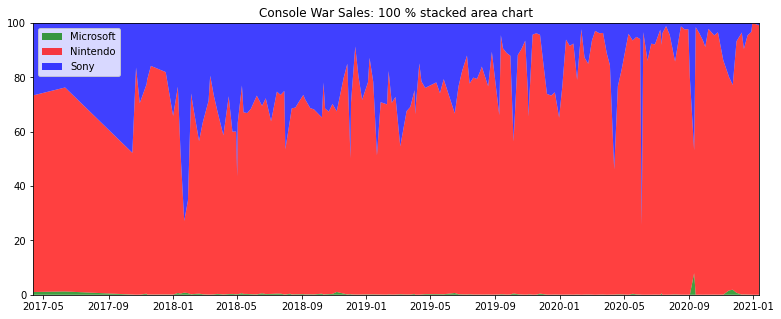

In [16]:
# Obtain weekly totals to normalize
suma=df_c["Microsoft"]+df_c["Nintendo"]+df_c["Sony"]

# Stacked area plot
plt.figure(figsize=(13,5))
plt.stackplot(df_c.index,  df_c["Microsoft"]*100/suma,  df_c["Nintendo"]*100/suma,  df_c["Sony"]*100/suma
              , labels=["Microsoft", "Nintendo","Sony"], colors = ["g","r","b"],baseline="zero", alpha=0.75)
plt.legend(loc='upper left')
plt.title('Console War Sales: 100 % stacked area chart')
plt.xlim(datetime.date(2017, 4, 12), datetime.date(2021, 1, 11))
plt.ylim(0,100)
plt.show()

And now... it's your turn to play with the dataset!